In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from MFEA_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task
from MFEA_lib.model.mfea import *
from MFEA_lib.model.utils import saveModel, loadModel, compareModel
from MFEA_lib.tasks.function import AbstractFunc
from MFEA_lib.operators import CrossOver, Mutation, Selection
from MFEA_lib.operators.CrossOver import *
from MFEA_lib.operators.Selection import *
from MFEA_lib.operators.Mutation import *
from MFEA_lib.tasks.Benchmark import CEC17_benchmark, GECCO20_benchmark_50tasks


In [2]:
class cus_MFEA(AbstractModel):
    pass


#### MFEA Variant
**Input:** K optimization tasks {$T_1, ..., T_K$}, num of generation: num_genergations $$=> \text{MAXEVALS} = num\_generations * num\_inds\_each\_task * K$$

**Output:** The best solutions of all tasks {$X_k^*, 1 \le k \le K$}

**Other Parameters:**
* dim_uss - dim of Unified search space
* N - nums inds each tasks
* $\text{nnp}_i$ (no name probability) - probability of choosing random sub-populations to get a mate for $\text{subpop}_i$

**Pseudo code:**

**begin**

&emsp;&emsp;for k $\larr$ 1 to K do:

&emsp;&emsp;&emsp;&emsp;eval_k = 0

&emsp;&emsp;Initialize population P(0) with K*N individuals;

&emsp;&emsp;Calculate the skill-factor for each individual in P(0)

&emsp;&emsp;Initialize M

&emsp;&emsp;t = 1

&emsp;&emsp;while the total number of evaluations < MAXEVALS:

&emsp;&emsp;&emsp;&emsp;Initialize offspring  O(t) $\larr$ $\emptyset$ 

&emsp;&emsp;&emsp;&emsp;while |O(t)| < |P(t)| do

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Randomize $\tau_{pa} \in \{1, ..., K\}$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Randomize $\tau_{pb} \in \{1, ..., K\}$ with distribution probability $\text{nnp}_{\tau_{pa}}$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Select $p_a \in$ $\text{subpop}_{\tau_{pa}}$ and $p_b \in$ $\text{subpop}_{\tau_{pb}}$ by tournament selection size 2

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;if $\tau_{pa} == \tau_{pb}$ and $f_{pa} > f_{pb}$:

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;swap(pa, pb)

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$o_a$, $o_b$ $\larr$ Crossover $p_a$, $p_b$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\tau_{oa}$, $\tau_{ob}$ $\larr$ $\tau_{pa}$, $\tau_{pa}$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;if $\tau_{pa} == \tau_{pb}$:

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$o_a$, $o_b$ $\larr$ Mutate $o_a$, $o_b$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Evaluate $o_a$, $o_b$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;O(t) $\larr$ O(t) $\cup$ {$o_a$, $o_b$}

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\Delta$ $\larr$ Calculate the maximum improvement percetage

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;if $\Delta> 0$ :

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Update $\text{nnp}_i$ with $\Delta$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Swap $p_a$ with better offspring ($o_a$ or $o_b$) 

&emsp;&emsp;&emsp;&emsp;$P(t+1) \larr P(t) \cup O(t)$    

&emsp;&emsp;&emsp;&emsp;Linear_Population_Size_Reduction(P(t+1))

&emsp;&emsp;&emsp;&emsp;Update crossover

**end**


**Calculate the maximum improvement percetage**

$$\Delta = \max(0,\frac{f_{\tau_{pa}}(p_a) - f_{\tau_{pa}}(o_a)}{f_{\tau_{pa}}(p_a)}, \frac{f_{\tau_{pa}}(p_a) - f_{\tau_{pa}}(o_b)}{f_{\tau_{pa}}(p_a)})$$ 

**newSBX**

**Input:** two parents $p_a, p_b$

**Output:** two offspring $o_a, o_b$

**begin**

&emsp;&emsp;if $\tau_{pa} == \tau_{pb}:$

&emsp;&emsp;&emsp;&emsp;oa, ob $\larr$ SBX_crossover, swap 50%

&emsp;&emsp;else:

&emsp;&emsp;&emsp;&emsp;$\text{prob}_{\tau_{pa}, \tau_{pb}}$ $\larr$ probability crossover in each dimension

&emsp;&emsp;&emsp;&emsp;p = random.rand(size = dim_uss)

&emsp;&emsp;&emsp;&emsp;oa, ob $\larr$ SBX_crossover pa, pb if p[i] < $\text{prob}_{\tau_{pa}, \tau_{pb}}$

**end**


In [3]:
class per_MFEA(AbstractModel):

    class battle_rmp:
        def __init__(self, idx_host: int, nb_tasks: int, lr, p_const_intra = 0.5):
            assert idx_host < nb_tasks
            self.idx_host = idx_host
            self.nb_tasks = nb_tasks
            # value const for intra
            self.p_const_intra = p_const_intra
            # rmp without const_val of host
            self.rmp_not_host = (np.ones((nb_tasks, )) - p_const_intra)/(nb_tasks)
            self.rmp_not_host[self.idx_host] += 1- p_const_intra - np.sum(self.rmp_not_host)

            self.rmp_include_host = self.get_rmp()
            self.lr = lr
            self.lower_p = 0.1/self.nb_tasks


        def get_rmp(self) -> np.ndarray:
            rmp_return = np.copy(self.rmp_not_host)

            rmp_return[self.idx_host] += self.p_const_intra

            return rmp_return

        def update_rmp(self, loc, Delta):
            '''
            Delta > 0
            '''
            for i in range(self.nb_tasks):
                if i != loc:
                    # d = Delta / (self.rmp_not_host[loc] / self.lower_p): solve unbalace prob
                    # lr = self.lr / self.nb_tasks: same eficicent for different nb_tasks
                    self.rmp_not_host[i] -= (Delta / (self.rmp_not_host[loc] / self.lower_p)) * self.lr / (self.nb_tasks - 1)
                    self.rmp_not_host[i] = np.clip(self.rmp_not_host[i], self.lower_p, 1)

            self.rmp_not_host[loc] += 1 - self.p_const_intra - np.sum(self.rmp_not_host)
        
            self.rmp_include_host = self.get_rmp()
            return self.rmp_include_host

    def compile(self, cross_over = CrossOver.SBX_CrossOver(), mutation =  Mutation.AbstractMutation(), selection= Selection.ElitismSelection()):
        self.cross_over = cross_over
        self.selection = selection  
        self.mutation = mutation

    def render_rmp(self, shape = None, title = None, figsize = None, dpi = 200, step = 1, get_host = False):
        if figsize is None:
            figsize = (30, 30)
        if title is None:
            title = self.__class__.__name__ + 'get_host = ' + str(get_host)
        if shape is None:
            shape = (int(np.ceil(len(self.tasks) / 3)), 3)
        else:
            assert shape[0] * shape[1] >= len(self.tasks)
        fig = plt.figure(figsize= figsize, dpi = dpi)
        fig.suptitle(title, size = 15)
        fig.set_facecolor("white")

        if not get_host:
            his_rmp = np.copy(self.history_rmp)
            for i in range(len(self.tasks)):
                his_rmp[:, i, i] -= 0.5
            y_lim = (-0.05, 0.55)
        else:
            his_rmp = np.copy(self.history_rmp)
            y_lim = (-0.1, 1.1)

        for i in range (len(self.tasks)):
            plt.subplot(shape[0], shape[1], i + 1)
            plt.stackplot(
                np.append(np.arange(0, len(his_rmp), step), np.array([len(his_rmp) - 1])),
                [his_rmp[
                    np.append(np.arange(0, len(his_rmp), step), np.array([len(his_rmp) - 1])), 
                    i, t] for t in range(len(self.tasks))],
                labels = ['task' + str(i + 1) for i in range(len(self.tasks))]
            )

            plt.legend()
            plt.title('task ' + str( i + 1))
            plt.xlabel("Epoch")
            plt.ylabel("M_rmp")
            plt.ylim(bottom = y_lim[0], top = y_lim[1])
        return fig

    def findParentTourament(self, idx_parents, pop_fcost, size = 2, not_replace = -1):
        res = not_replace
        while res == not_replace:
            idxs = np.random.choice(idx_parents, size= size, replace= False)
            res = idxs[np.argmin(pop_fcost[idxs])]
        return res

        # idx_p1, idx_p2 = np.random.choice(idx_parents, size= 2, replace= False)
        # return (idx_p1, idx_p2)[np.argmin([pop_fcost[idx_p1], pop_fcost[idx_p2]])]

    def fit(self, tasks: list[AbstractFunc], num_epochs, num_inds_each_task=100, nb_inds_min = None, 
                lr = 0.01, nb_epochs_stop = 10, tourament_size = 2, p_const_intra = 0.5, rate = 0.5, 
                evaluate_initial_skillFactor=True, range_init_pop= [0, 1]) -> tuple[list[np.ndarray], np.ndarray]:
                # LSA or SA
        if nb_inds_min is not None:
            assert num_inds_each_task >= nb_inds_min
        else:
            nb_inds_min = num_inds_each_task
            
        self.tasks = tasks

        # initial history of factorial cost -> for render
        self.history_cost = np.empty((0, len(tasks)), np.float) 
        self.history_rmp = []
        self.history_crossover_exp_rate = []

        # dim of Unified search space
        dim_uss = max([t.dim for t in tasks])
        
        #NOTE get dim_uss for crossover
        self.cross_over.get_dim_uss(dim_uss)

        # initial population
        inf, sup = range_init_pop
        population, skill_factor_arr = population_init(
            N = num_inds_each_task,
            num_tasks= len(tasks),
            d = dim_uss,
            min_val= inf,
            max_val= sup
        )

        if evaluate_initial_skillFactor:
            skill_factor_arr = skill_factor_best_task(population, tasks)
        pop_fcost = factorial_cost(population, skill_factor_arr, tasks)
        pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))

        # SA params:
        MAXEVALS = num_epochs * num_inds_each_task * len(tasks)
        eval_k = np.zeros(len(tasks))
        epoch = 0

        ''' 
        -------
        per params
        -------
        '''
        # prob choose first parent
        p_choose_father = np.array([1/len(tasks) for i in range(len(tasks))])
        tasks_waiting =np.zeros((len(tasks), ))
        # count_eval_stop: nums evals not decrease factorial cost
        # maxcount_es: max of count_eval_stop
        # if count_eval[i] == maxcount_es: p_choose_father[i] == 0
        count_eval_stop = [0] * len(tasks)
        maxcount_es = nb_epochs_stop * num_inds_each_task
        # index of population: -1 is parent, 0 -> len(offspring) is index of offspring
        index_pop = -1 * np.ones_like(skill_factor_arr)

        # Initial success history memory M_rmp
        M_rmp = [self.battle_rmp(i, len(tasks), lr, p_const_intra= p_const_intra) for i in range(len(tasks))]


        # save history_cost
        self.history_cost = np.append(self.history_cost, 
            [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
            axis = 0
        )
        self.history_rmp.append([M_rmp[i].get_rmp() for i in range(len(tasks))])
        self.history_crossover_exp_rate.append(self.cross_over.exp_rate)
        epoch = 1

        while np.sum(eval_k) <= MAXEVALS:
            count_eval = 0

            # initial offspring of next generation
            offspring = np.empty((0, dim_uss))
            offspring_skill_factor = np.empty((0, ), np.int)
            offspring_fcost = np.empty((0, ))
            # index offspring
            index_offspring = np.empty((0, ), np.int)

            while count_eval < len(population):
                if np.sum(eval_k) >= epoch * num_inds_each_task * len(tasks):
                    #save history
                    self.history_cost = np.append(self.history_cost, 
                        [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
                        axis = 0
                    ) 
                    self.history_rmp.append([M_rmp[i].get_rmp() for i in range(len(tasks))])
                    self.history_crossover_exp_rate.append(self.cross_over.exp_rate)

                    #print
                    sys.stdout.write('\r')
                    sys.stdout.write('Epoch {}, [%-10s] %3d%% ,pop_size: {}, func_val: {}'
                        .format(epoch, len(population),[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
                        % ('=' * np.int((np.sum(eval_k) + 1) // (MAXEVALS // 10)) + '>' , (np.sum(eval_k) + 1) * 100 // MAXEVALS)
                        )
                    sys.stdout.flush()

                    epoch += 1
                
                # choose father
                skf_pa = np.random.choice(np.arange(len(tasks)), p = p_choose_father)

                # random with prob rmp
                # get rmp
                rmp = M_rmp[skf_pa].get_rmp()

                # pb with rmp
                skf_pb = np.random.choice(np.arange(len(tasks)), p = rmp)
                # if skf_pb == skf_pa: type_crossover = 'intra'
                # else: type_crossover = 'inter'

                #find parent
                idx_pa = self.findParentTourament(np.where(skill_factor_arr == skf_pa)[0], pop_fcost, size = tourament_size)
                idx_pb = self.findParentTourament(np.where(skill_factor_arr == skf_pb)[0], pop_fcost, size = tourament_size, not_replace = idx_pa)                

                if skf_pa == skf_pb and pop_fcost[idx_pa] > pop_fcost[idx_pb]:
                    idx_pa, idx_pb = idx_pb, idx_pa 

                pa, pb = population[idx_pa], population[idx_pb]

                oa, ob = self.cross_over(pa, pb, (skf_pa, skf_pb))

                if skf_pa == skf_pb:
                    mutation: AbstractMutation = self.mutation
                    scale_mutation = np.abs(pa - pb) * rate
                    oa, ob = mutation(oa, scale = scale_mutation, pa = pa, pb = pb), mutation(ob, scale = scale_mutation, pa = pa, pb = pb)
                
                skf_oa, skf_ob = skf_pa, skf_pa

                # Evaluate oa, ob
                fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)

                index_offspring = np.append(index_offspring, [count_eval, count_eval + 1], axis = 0)
                offspring = np.append(offspring, [oa, ob], axis = 0)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob], axis = 0)
                offspring_fcost = np.append(offspring_fcost, [fcost_oa, fcost_ob], axis = 0)
                count_eval += 2
                eval_k[skf_pa] += 2

                # Calculate the maximum improvement percetage
                Delta1 = (pop_fcost[idx_pa] - fcost_oa)/(pop_fcost[idx_pa] + 1e-100)
                Delta2 = (pop_fcost[idx_pa] - fcost_ob)/(pop_fcost[idx_pa] + 1e-100)

                self.cross_over.get_eval((Delta1 > 0, Delta2 > 0))

                # if Delta > 0:
                #NOTE
                if Delta1 > 0 or Delta2 > 0:
                    if Delta1 > Delta2:
                        # swap parent a and child 1
                        population[idx_pa], offspring[-2] = offspring[-2], population[idx_pa]
                        pop_fcost[idx_pa], offspring_fcost[-2] = offspring_fcost[-2], pop_fcost[idx_pa]
                        #same skill_factor => not swap
                        index_pop[idx_pa], index_offspring[-2] = index_offspring[-2], index_pop[idx_pa]

                        # update M_rmp
                        M_rmp[skf_pa].update_rmp(skf_pb, Delta1)
                        
                        if skf_pa == skf_pb and Delta2 > 0:
                            # swap parent b and child 2
                            population[idx_pb], offspring[-1] = offspring[-1], population[idx_pb]
                            pop_fcost[idx_pb], offspring_fcost[-1] = offspring_fcost[-1], pop_fcost[idx_pb]
                            #same skill_factor => not swap
                            index_pop[idx_pb], index_offspring[-1] = index_offspring[-1], index_pop[idx_pb]
                    else:
                        # swap parent a and child 2
                        population[idx_pa], offspring[-1] = offspring[-1], population[idx_pa]
                        pop_fcost[idx_pa], offspring_fcost[-1] = offspring_fcost[-1], pop_fcost[idx_pa]
                        #same skill_factor => not swap
                        index_pop[idx_pa], index_offspring[-1] = index_offspring[-1], index_pop[idx_pa]

                        # update M_rmp
                        M_rmp[skf_pa].update_rmp(skf_pb, Delta2)

                        if skf_pa == skf_pb and Delta1 > 0:
                            # swap parent b and child 2
                            population[idx_pb], offspring[-2] = offspring[-2], population[idx_pb]
                            pop_fcost[idx_pb], offspring_fcost[-2] = offspring_fcost[-2], pop_fcost[idx_pb]
                            #same skill_factor => not swap
                            index_pop[idx_pb], index_offspring[-2] = index_offspring[-2], index_pop[idx_pb]
                    
                    # reset count_eval_stop
                    count_eval_stop[skf_pa] = 0
                else:
                    # count eval not decrease
                    count_eval_stop[skf_pa] += 1

                if count_eval_stop[skf_pa] == maxcount_es:
                    tasks_waiting[skf_pa] = 1

                    # if all tasks is waiting
                    if np.sum(tasks_waiting) == len(tasks):
                        tasks_waiting[np.where(self.history_cost[-1] > 0)[0]] = 0
                        if np.sum(tasks_waiting) == len(tasks):
                            tasks_waiting[:] = 0

                    idx_waiting = (tasks_waiting == 1)
                    p_choose_father = np.where(idx_waiting, 0.1 * 1/len(tasks), p_choose_father)
                    p_choose_father = np.where(idx_waiting, p_choose_father, (1 - np.sum(p_choose_father[idx_waiting]))/np.sum(1 - idx_waiting)) 

                elif count_eval_stop[skf_pa] == 0:
                    tasks_waiting[skf_pa] = 0
                    if np.sum(tasks_waiting) == len(tasks):
                            tasks_waiting[:] = 0

                    idx_waiting = (tasks_waiting == 1)
                    p_choose_father = np.where(idx_waiting, 0.1 * 1/len(tasks), p_choose_father)
                    p_choose_father = np.where(idx_waiting, p_choose_father, (1 - np.sum(p_choose_father[idx_waiting]))/np.sum(1 - idx_waiting)) 
            
            # merge
            population = np.append(offspring, population, axis = 0)
            skill_factor_arr = np.append(offspring_skill_factor, skill_factor_arr, axis = 0)
            pop_fcost = np.append(offspring_fcost, pop_fcost, axis = 0)
            index_pop = np.append(index_offspring, index_pop, axis = 0)

            # selection
            #-----------
            pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))
            nb_inds_tasks = [
                int(min((nb_inds_min - num_inds_each_task)/(num_epochs - 1)* (epoch - 1) + num_inds_each_task, num_inds_each_task))
            ]*len(tasks)
            idx = self.selection(skill_factor_arr, pop_fitness, nb_inds_tasks= nb_inds_tasks)

            self.cross_over.update(index_pop[idx[np.where(index_pop[idx] > -1)[0]]])

            population = population[idx]
            skill_factor_arr = skill_factor_arr[idx]
            pop_fcost = pop_fcost[idx]
            index_pop = -1 * np.ones_like(skill_factor_arr)
            #-----------

        #solve
        sol_idx = [np.argmin(pop_fcost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
        self.solve = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]
        print()
        print(p_choose_father)
        print(eval_k)
        return self.solve, self.history_cost

    def get_results(nb_run):
        pass

In [4]:
cec17_10tasks = CEC17_benchmark.get_10tasks_benchmark(fix = False)

In [5]:
per_model = per_MFEA()

per_model.compile(
    cross_over = newSBX(len(cec17_10tasks), nc = 2, gamma = 0.6, num_epochs_save_mem = 50),
    mutation = NoMutation(), 
    # mutation = GMDScale(),
    selection= ElitismSelection()
)

sol, his = per_model.fit(tasks = cec17_10tasks, num_epochs= 1000, num_inds_each_task= 100, nb_inds_min= 30, 
                nb_epochs_stop = 30, rate = 0.8, p_const_intra = 0.2, lr = 1, 
                evaluate_initial_skillFactor= True)
                
saveModel(per_model, "./RESULTS/cec17_per_MFEA.mso")

Epoch 1000, [==========>] 100% ,pop_size: 300, func_val: [1.0703264762038688e-26, 8.077935669463161e-28, 0.0, 0.0, 12.283375651255042, 7.105427357601002e-15, 0.0, 0.0006363783177221194, 0.0, 0.9949590570934106]49590570977875]8]]49590674150954]950111366871965]9]]]1988867]]6]6]
[0.01 0.46 0.01 0.01 0.46 0.01 0.01 0.01 0.01 0.01]
[ 89894. 123438.  70398.  43348. 264984. 124168.  62056.  95076.  53218.
  73560.]


'Saved'

In [6]:
per_model.history_cost[-1]

array([1.07032648e-26, 8.07793567e-28, 0.00000000e+00, 0.00000000e+00,
       1.22833757e+01, 7.10542736e-15, 0.00000000e+00, 6.36378318e-04,
       0.00000000e+00, 9.94959057e-01])

In [7]:
model1 = loadModel("./RESULTS/cec17_mfea1.mso")

base_model = loadModel("./RESULTS/cec17_mfeabase.mso")

sa_model = loadModel("./RESULTS/cec17_sa_mfea.mso")

lsa_model = loadModel("./RESULTS/cec17_lsa_mfea.mso")

per_model:per_MFEA = loadModel("./RESULTS/cec17_per_MFEA.mso")

# per_Lmodel:per_MFEA = loadModel("./RESULTS/cec17fixed_per_LMFEA.mso")

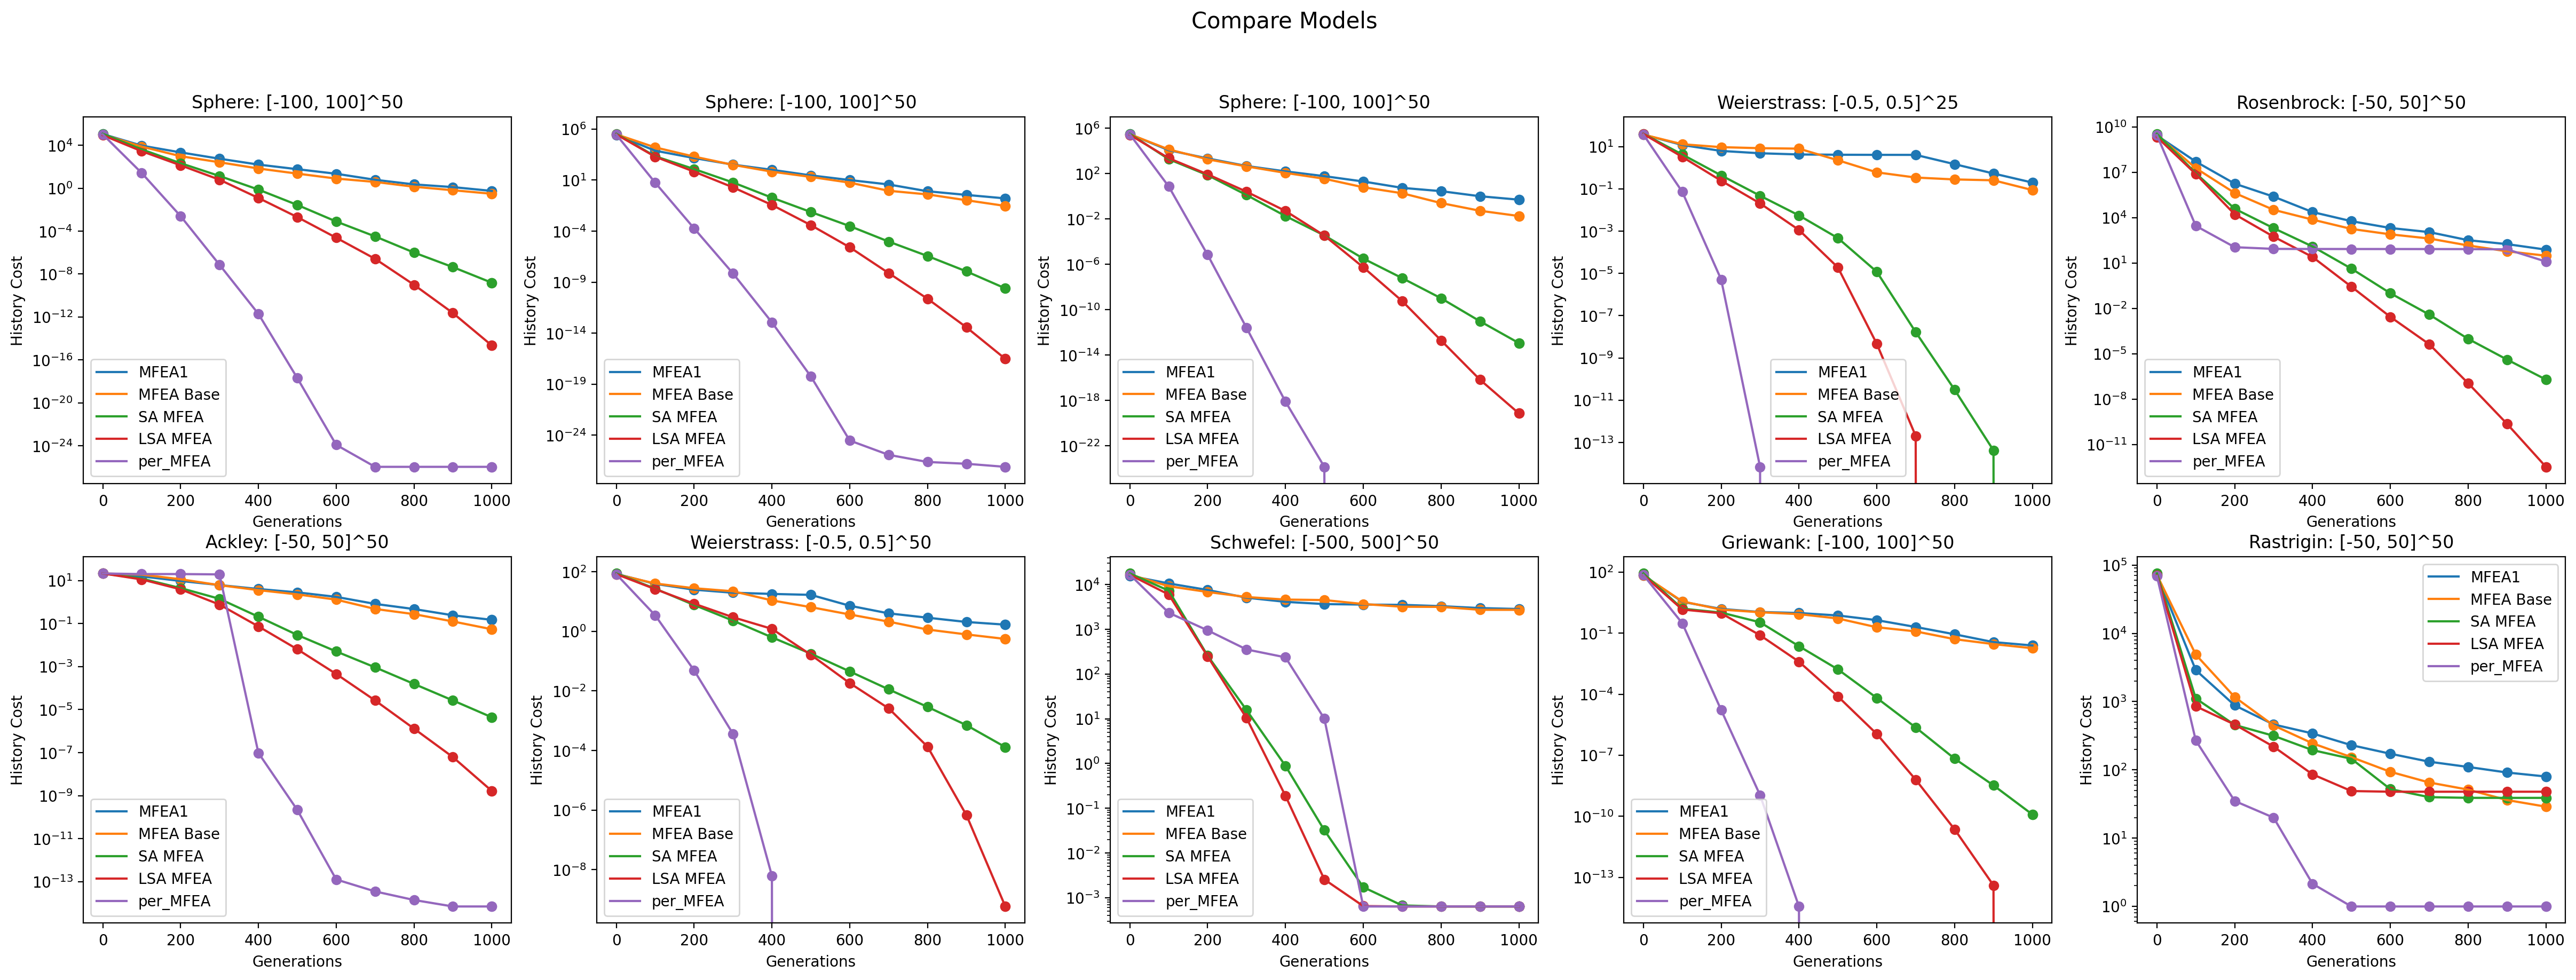

In [8]:
compareModel(
    models= [model1, base_model, sa_model, lsa_model, per_model],
    label_legend=  ["MFEA1", "MFEA Base", "SA MFEA", "LSA MFEA", "per_MFEA"],
    tasks= cec17_10tasks,
    shape= (2, 5),
    step= 100,
    yscale= 'log'
)
print()

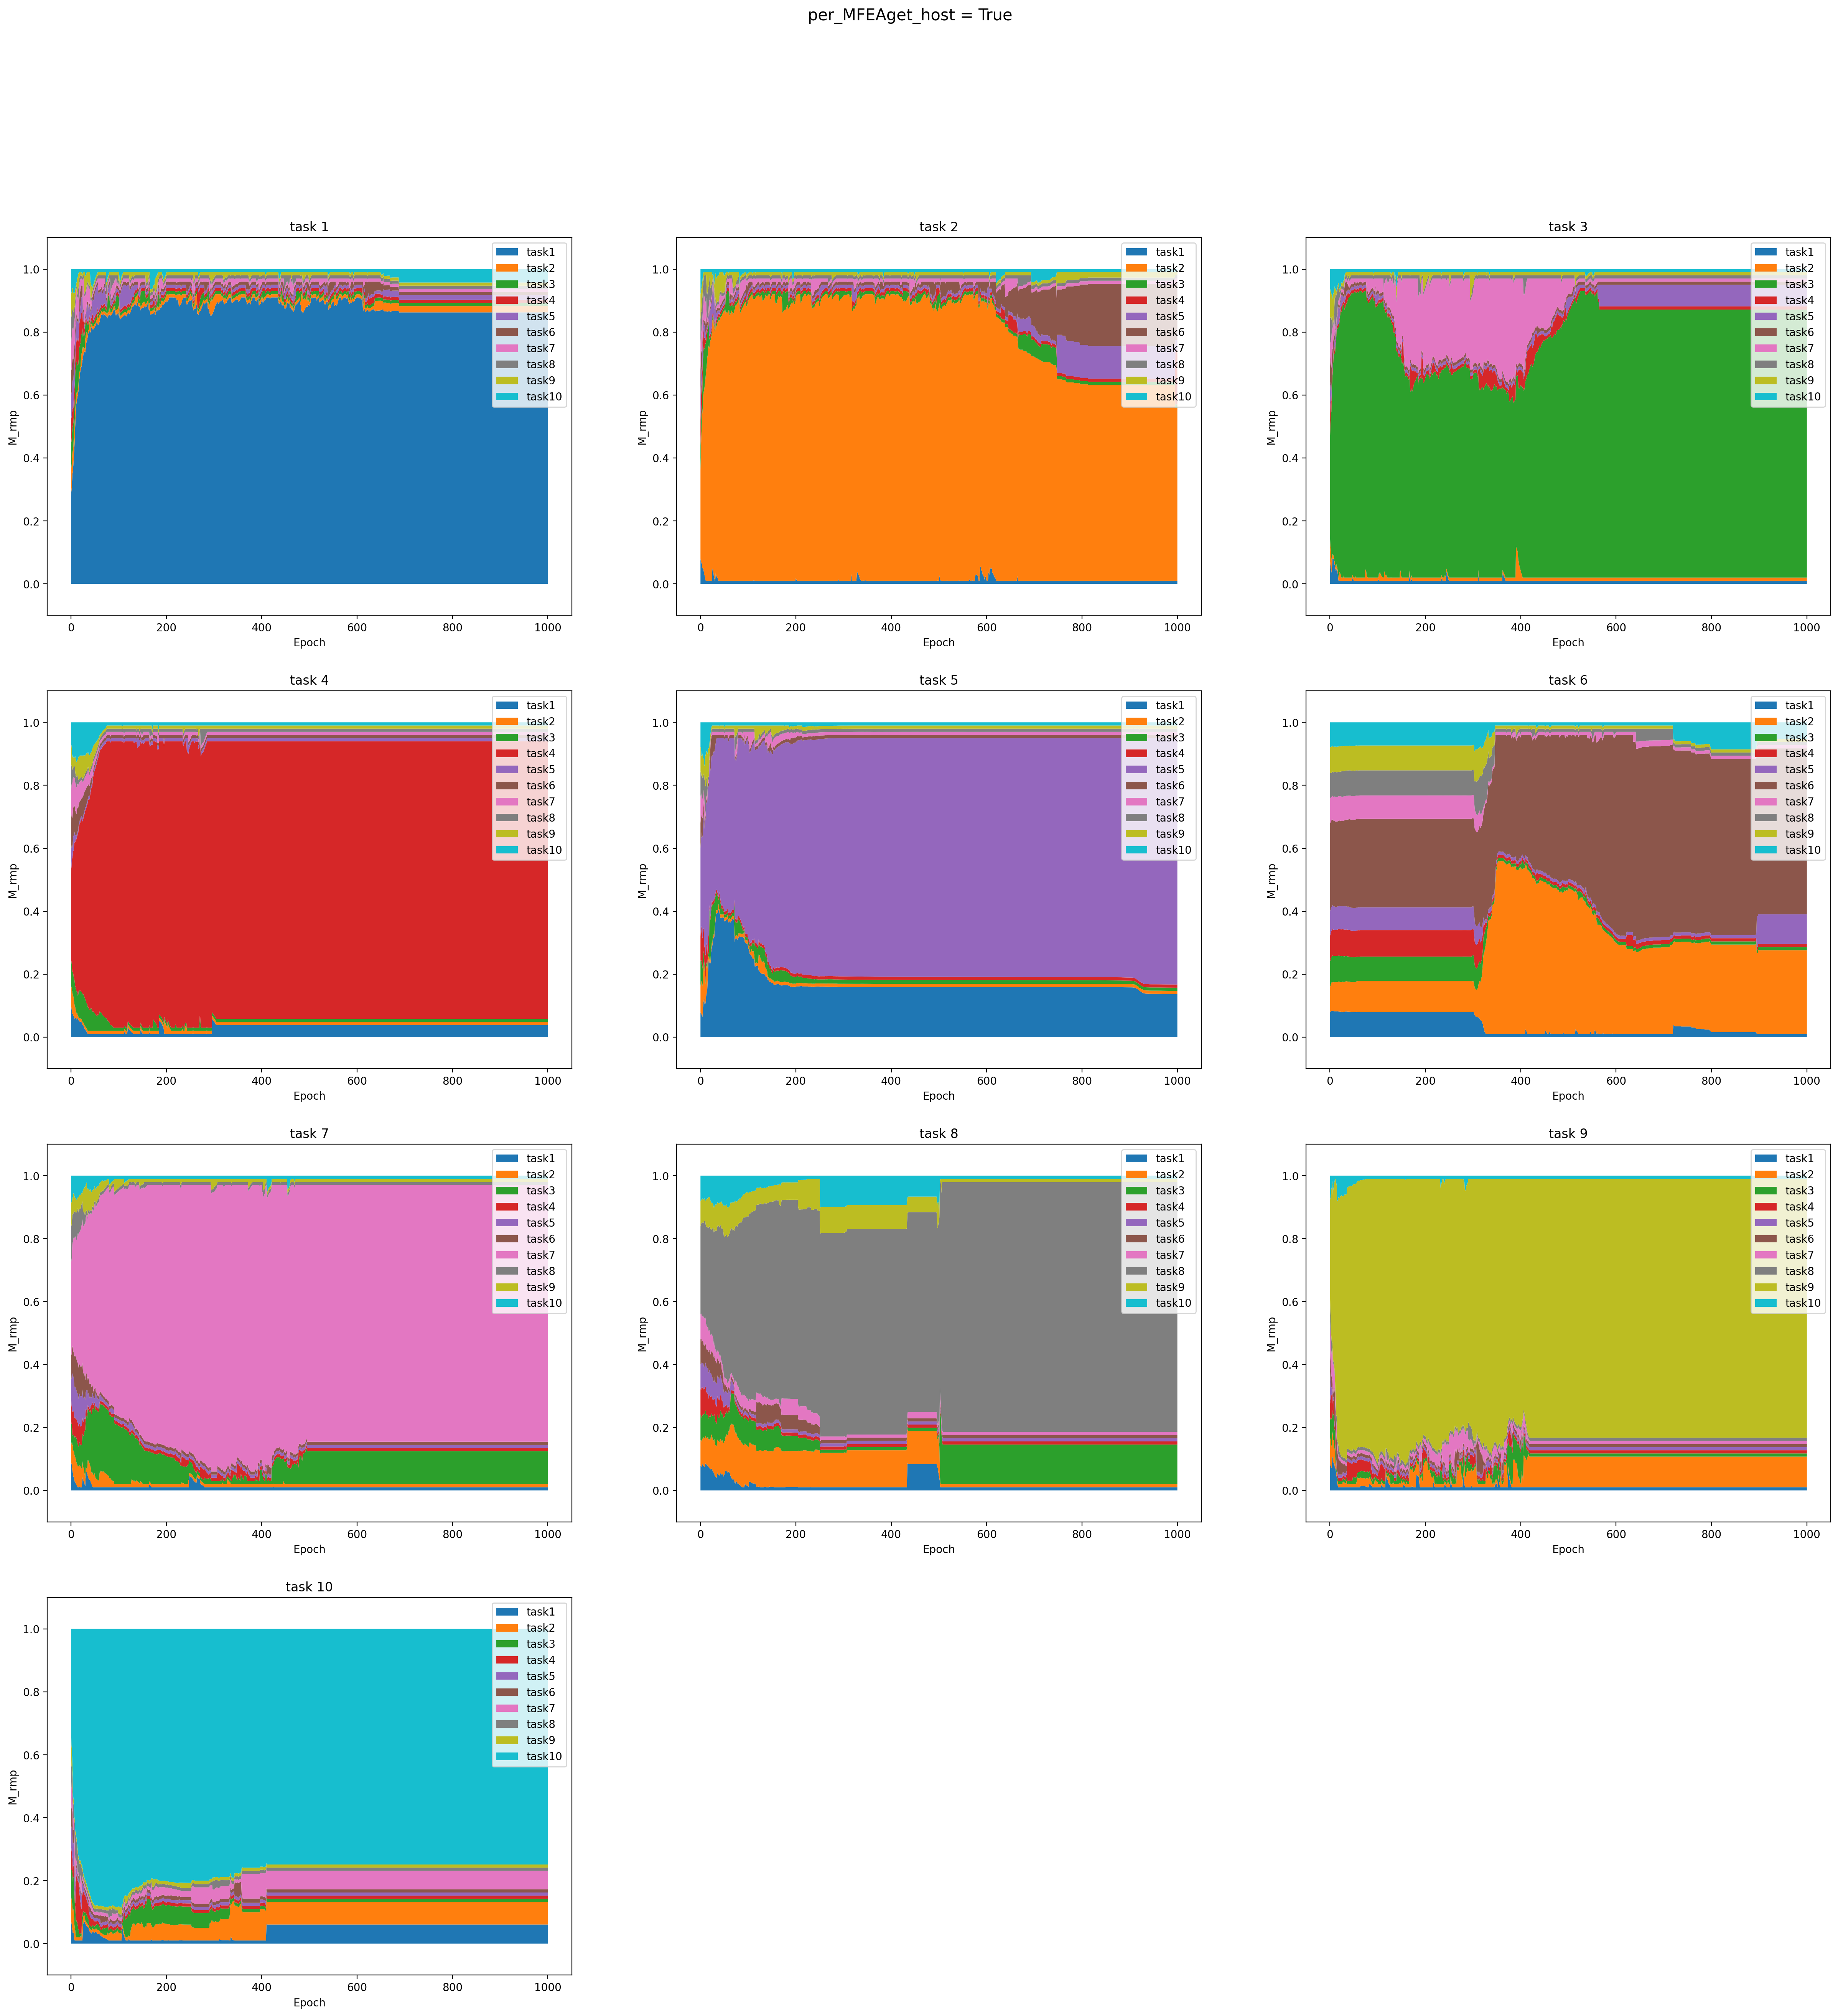

In [9]:
per_model.render_rmp(step = 1, get_host= True)
print()